#Preperation

In [ ]:
!git clone #anonymous github

In [ ]:
!pip install wget
!pip install lime
!pip install glm-saga
!pip install transformers
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 28.7 MB/s 


In [ ]:
%cd MultiViz/structured-framework/

/content/MultiViz/structured-framework


In [ ]:
!mkdir data
%cd data

/content/MultiViz/structured-framework/data


In [ ]:
!wget https://dl.fbaipublicfiles.com/clevr/CLEVR_v1.0.zip
!unzip CLEVR_v1.0.zip


Streaming output truncated to the last 5000 lines.
  inflating: CLEVR_v1.0/images/train/CLEVR_train_041020.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_068755.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_008504.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057028.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_057464.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_049590.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010322.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_038692.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_047594.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014228.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_010552.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_030689.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_044484.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_026813.png  
  inflating: CLEVR_v1.0/images/train/CLEVR_train_014422.png  
  inflating: CLEVR_

In [ ]:
%cd ../models

In [ ]:
!mv mdetr-extras mdetr_extras

In [ ]:
%cd mdetr_extras

/content/MultiViz/structured-framework/models/mdetr


In [ ]:
%%writefile requirements.txt
torch==1.7.0
torchvision>=0.6.0
cython
scipy
xmltodict
tqdm
transformers==4.5.1
onnx
onnxruntime
prettytable
submitit
git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI&egg=pycocotools
git+https://github.com/cocodataset/panopticapi.git#egg=panopticapi
timm

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-udmexer5/pycocotools_a69aeaf372944e49b1cec94c6c3ad300
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-install-udmexer5/pycocotools_a69aeaf372944e49b1cec94c6c3ad300
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-udmexer5/panopticapi_2df33ac8c6b7401a8c5fc5a7c4462f3c
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-install-udmexer5/panopticapi_2df33ac8c6b7401a8c5fc5a7c4462f3c


Note: upload the trained mdetr model clevr_model_2.pt

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
%cd /content/MultiViz/structured-framework

/content/MultiViz/structured-framework


In [ ]:
!mkdir tmp
!mkdir visuals

#Define CLEVR_MDETR analysis model

Note: following the definition of the abstract analysis model definition in analysismodel.py to define the CLEVR_MDETR model

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import json
import torch.nn.functional as F
import numpy as np
import copy
import cv2
import PIL
import random

from models.analysismodel import analysismodel

sys.path.insert(
    1, "/content/MultiViz/structured-framework/models/mdetr_extras"
)
import models.mdetr_extras.dataset.transforms as T



class CLEVRMDETR:
    def __init__(self, device="cuda"):
        self.device = device
        self.model = torch.load("models/mdetr_extras/clevr_model_2.pt")
        self.dummy_info = None
        self.modalitynames = ["image", "text"]
        self.modalitytypes = ["image", "text"]
        

    # non-api functions
    def make_clevr_transforms(self, cautious=False):
        normalize = T.Compose(
            [T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        )
        # scales = [256, 288, 320, 352, 384]

        return T.Compose(
            [
                normalize,
            ]
        )


    def get_normed(self, img, target):
        tmp = copy.deepcopy(target)
        img, _ = self.make_clevr_transforms()(img, tmp)
        return img

    def pred_answer(self, outputs):
        idx = 0
        ans_type = int(outputs["pred_answer_type"].argmax(-1))
        if ans_type == 0:
            idx = int(not (outputs["pred_answer_binary"].sigmoid() > 0.5))
        elif ans_type == 1:
            idx = int(outputs["pred_answer_attr"].argmax(-1)) + 2
        else:
            idx = int(outputs["pred_answer_reg"].argmax(-1)) + 17
        return idx

    # end non-api functions

    def getmodalitynames(self):
      return self.modalitynames
    
    def getmodalitytypes(self):
      return self.modalitytypes

    def getunimodaldata(self, datainstance, modality):
        if modality == "image":
            return np.asarray(PIL.Image.open(datainstance[0]).convert("RGB"))
        elif modality == "text":
            return datainstance[1]
        else:
            raise ValueError

    def getcorrectlabel(self, datainstance):
        return datainstance[3]

    def forward(self, datainstance):
        with torch.no_grad():
            image = PIL.Image.open(datainstance[0]).convert("RGB")
            normed_image = self.get_normed(image, self.dummy_info)
            samples = torch.unsqueeze(normed_image, 0).to(self.device)
            captions = [datainstance[1]]

            model_features = []

            def hook(module, input, output):
                nonlocal model_features
                model_feat = input
                model_features.append(model_feat[0][0])

            handle1 = self.model.answer_type_head.register_forward_hook(hook)
            handle2 = self.model.answer_binary_head.register_forward_hook(hook)
            handle3 = self.model.answer_attr_head.register_forward_hook(hook)
            handle4 = self.model.answer_reg_head.register_forward_hook(hook)

            memory_cache = self.model(samples, captions, encode_and_save=True)
            outputs = self.model(
                samples, captions, encode_and_save=False, memory_cache=memory_cache
            )
            pred_answer_binary_comp = -outputs["pred_answer_binary"]
            probas = torch.cat(
                (
                    outputs["pred_answer_binary"].unsqueeze(0).T,
                    pred_answer_binary_comp.unsqueeze(0).T,
                    outputs["pred_answer_attr"],
                    outputs["pred_answer_reg"],
                ),
                1,
            )

            handle1.remove()
            handle2.remove()
            handle3.remove()
            handle4.remove()

            return (
                probas[0],
                outputs,
                torch.cat(model_features),
            )  

    # in this case we don't do batching, so we just do one at a time:
    def forwardbatch(self, datainstances):
        outs = []
        for di in datainstances:
            outs.append(self.forward(di))
        return outs

    def getlogitsize(self):
        return 37

    def getlogit(self, resultobj):
        return resultobj[0]

    def getprelinear(self, resultobj):
        return resultobj[2]

    def getpredlabel(self, resultobj):
        return self.pred_answer(resultobj[1])

    def getprelinearsize(self):
        return 256 * 4

    def replaceunimodaldata(self, datainstance, modality, newinput):
        if modality == "image":
            randname = "tmp/clevr" + str(random.randint(0, 100000000)) + ".jpg"
            plt.imsave(randname, newinput)
            return randname, datainstance[1], datainstance[2], datainstance[3]
        elif modality == "text":
            return datainstance[0], newinput, datainstance[2], datainstance[3]
        else:
            raise ValueError

    def getgrad(self, datainstance, target, prelinear=False):
        self.model.zero_grad()
        imgfile = datainstance[0]
        image = PIL.Image.open(imgfile).convert("RGB")
        normed_image = self.get_normed(image, self.dummy_info).to(self.device)

        normed_image.requires_grad = True

        samples = torch.unsqueeze(normed_image, 0).to(self.device)
        captions = [datainstance[1]]

        if prelinear:
            model_features = []

            def hook(module, input, output):
                nonlocal model_features
                model_feat = input
                model_features.append(model_feat[0][0])

            handle1 = self.model.answer_type_head.register_forward_hook(hook)
            handle2 = self.model.answer_binary_head.register_forward_hook(hook)
            handle3 = self.model.answer_attr_head.register_forward_hook(hook)
            handle4 = self.model.answer_reg_head.register_forward_hook(hook)

        memory_cache = self.model(samples, captions, encode_and_save=True)
        outputs = self.model(
            samples, captions, encode_and_save=False, memory_cache=memory_cache
        )
        pred_answer_binary_comp = -outputs["pred_answer_binary"]
        probas = torch.cat(
            (
                outputs["pred_answer_binary"].unsqueeze(0).T,
                pred_answer_binary_comp.unsqueeze(0).T,
                outputs["pred_answer_attr"],
                outputs["pred_answer_reg"],
            ),
            1,
        )

        if prelinear:
            feats = torch.cat(model_features)
            feats[target].backward()
        else:
            probas[0][target].backward()
        grad = normed_image.grad.detach()
        if prelinear:

            handle1.remove()
            handle2.remove()
            handle3.remove()
            handle4.remove()
        return normed_image, grad, imgfile

    def getgradtext(self, datainstance, target, alltarget=False, prelinear=False):
        self.model.zero_grad()
        image = PIL.Image.open(datainstance[0]).convert("RGB")
        normed_image = self.get_normed(image, self.dummy_info)
        normed_image.requires_grad = True
        samples = torch.unsqueeze(normed_image, 0).to(self.device)
        captions = [datainstance[1]]

        text_embedding = None
        text_ids = None
        gradd = None

        def hook_forward(module, input, output):
            nonlocal text_embedding, text_ids
            text_embedding = output[0]
            text_ids = input[0]

        def hook_backward(module, input, output):
            nonlocal gradd
            print("called4")
            gradd = output[0][0]
            # print(grad)

        handle = self.model.transformer.text_encoder.embeddings.word_embeddings.register_forward_hook(
            hook_forward
        )
        handle22 = self.model.transformer.text_encoder.embeddings.word_embeddings.register_backward_hook(
            hook_backward
        )

        if prelinear:
            model_features = []

            def hook(module, input, output):
                nonlocal model_features
                model_feat = input
                model_features.append(model_feat[0][0])

            handle1 = self.model.answer_type_head.register_forward_hook(hook)
            handle2 = self.model.answer_binary_head.register_forward_hook(hook)
            handle3 = self.model.answer_attr_head.register_forward_hook(hook)
            handle4 = self.model.answer_reg_head.register_forward_hook(hook)
        memory_cache = self.model(samples, captions, encode_and_save=True)

        outputs = self.model(
            samples, captions, encode_and_save=False, memory_cache=memory_cache
        )
        pred_answer_binary_comp = -outputs["pred_answer_binary"]
        probas = torch.cat(
            (
                outputs["pred_answer_binary"].unsqueeze(0).T,
                pred_answer_binary_comp.unsqueeze(0).T,
                outputs["pred_answer_attr"],
                outputs["pred_answer_reg"],
            ),
            1,
        )

        if alltarget:
            torch.sum(probas[0]).backward(create_graph=True)
        elif prelinear:
            feats = torch.cat(model_features)
            feats[target].backward()
        else:
            probas[0][target].backward()

        handle.remove()
        handle22.remove()

        res = torch.sum(text_embedding * gradd, dim=1)
        if prelinear:
            handle1.remove()
            handle2.remove()
            handle3.remove()
            handle4.remove()

        print(datainstance[1])
        print(parse(datainstance[1]))
        print(res)
        return res, parse(datainstance[1]), normed_image, text_ids

    def getdoublegrad(self, datainstance, target, targetwords, alltarget=True):
        res, di, normed_image, text_ids = self.getgradtext(
            datainstance, target, alltarget=alltarget
        )
        ac = 0.0
        for id in targetwords:
            ac += torch.abs(res[id])

        rets = torch.autograd.grad(ac, normed_image)
        return rets[0], di, text_ids


def parse(sent):
    words = []
    for word in sent[:-1].split(" "):
        if word[-1].isalnum():
            words.append(word)
        else:
            words.append(word[:-1])
            words.append(word[-1])
    words.append("?")
    words.append("<end>")
    words.insert(0, "<start>")
    return words

#CLEVR_MDETR analysis

In [ ]:
import PIL.Image as Image

from datasets.clevr import CLEVRDataset
from visualizations.visualizelime import visualizelime

from analysis.emap import emap_print_report
from analysis.dime import dime
from analysis.unimodallime import rununimodallime
from visualizations.visualizegradient import*

In [ ]:
#processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
#model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

datas = CLEVRDataset("val")
analysismodel = CLEVRMDETR()

###Gradient-based


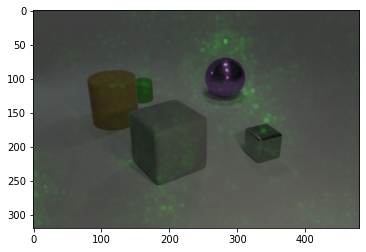

In [ ]:
# define a wrapper for visualizing saliency map using our visualization
# functions from visualizations.visualizegradient
def generate_grad(dataset, model, idx, target, image_out, text_out, prelinear=False):
    data_instance = dataset.getdata(idx)
    imgfile = data_instance[0]
    _, grad, _ = model.getgrad(data_instance, target)

    grads = torch.sum(torch.abs(grad).squeeze(), dim=0)
    t = normalize255(grads)
    heatmap2d(t, image_out, imgfile)  

idx = 5
target = 3
generate_grad(datas, analysismodel, idx, target, f"visuals/clevr-mdetr-{idx}-image-grad-{target}.png", f"visuals/clevr-mdetr-{idx}-image-grad-{target}.png")




###Unimodal Lime

In [ ]:
# pick data instance you want to explain
instance = datas.getdata(554)
# get the model predicted label
predlabel = analysismodel.getpredlabel(analysismodel.forward(instance))
# get the correct label
correctlabel = analysismodel.getcorrectlabel(instance)
# generate lime explanation for image modality on both correct label and predicted label
explanation1 = rununimodallime(
    instance, "image", "image", analysismodel, (predlabel, correctlabel)
)
# generate lime explanation for text modality on both correct label and predicted label
explanation2 = rununimodallime(
    instance,
    "text",
    "text",
    analysismodel,
    (predlabel, correctlabel),
    class_names=datas.classnames(),
)
# visualize explanations and save to directory
visualizelime(
    explanation1, "image", predlabel, "visuals/clevr-mdetr-554-image-lime-pred.png"
)
visualizelime(
    explanation1, "image", correctlabel, "visuals/clevr-mdetr-554-image-lime-correct.png"
)
visualizelime(
    explanation2, "text", predlabel, "visuals/clevr-mdetr-554-text-lime-pred.png"
)
visualizelime(
    explanation2, "text", correctlabel, "visuals/clevr-mdetr-554-text-lime-correct.png"
)

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

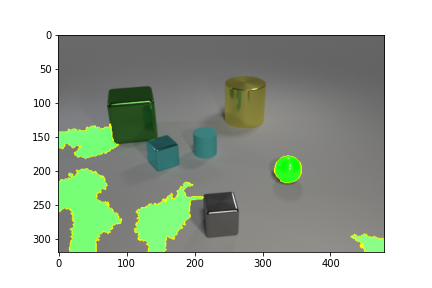

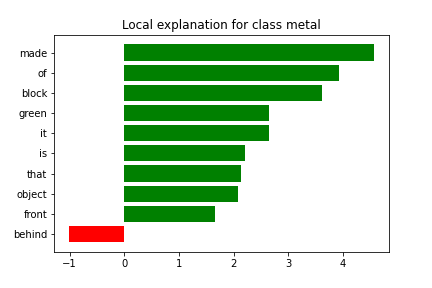

In [ ]:
display(Image.open("visuals/clevr-mdetr-554-image-lime-pred.png"))
display(Image.open("visuals/clevr-mdetr-554-text-lime-pred.png"))

###DIME

In [ ]:
# pick data instance you want to explain
instance = datas.getdata(554)
# get the model predicted label
predlabel = analysismodel.getpredlabel(analysismodel.forward(instance))
# get the correct label
correctlabel = analysismodel.getcorrectlabel(instance)
# run dime
instances = []

for i in range(100):
    instances.append(datas.getdata(i * 50 + 4))

explanations = dime(
    instances, 11, analysismodel, [predlabel, correctlabel]
)

# visualize explanations and save to directory
visualizelime(
    explanations[0], "image", 0, "visuals/clevr-mdetr-554-image-dime-pred-uni.png"
)
visualizelime(
    explanations[0], "image", 2, "visuals/clevr-mdetr-554-image-dime-correct-uni.png"
)
visualizelime(
    explanations[0], "image", 1, "visuals/clevr-mdetr-554-image-dime-pred-multi.png"
)
visualizelime(
    explanations[0], "image", 3, "visuals/clevr-mdetr-554-image-dime-correct-multi.png"
)
visualizelime(
    explanations[1], "text", 0, "visuals/clevr-mdetr-554-text-dime-pred-uni.png"
)
visualizelime(
    explanations[1], "text", 2, "visuals/clevr-mdetr-554-text-lime-correct-uni.png"
)
visualizelime(
    explanations[1], "text", 1, "visuals/clevr-mdetr-554-text-dime-pred-multi.png"
)
visualizelime(
    explanations[1], "text", 3, "visuals/clevr-mdetr-554-text-lime-correct-multi.png"
)

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

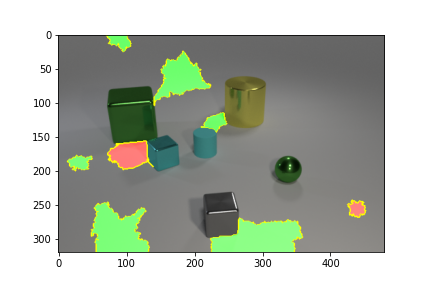

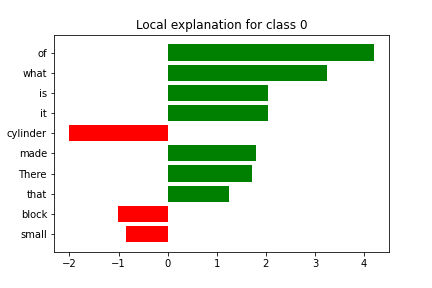

In [ ]:
display(Image.open("visuals/clevr-mdetr-554-image-dime-pred-uni.png"))
display(Image.open("visuals/clevr-mdetr-554-text-dime-pred-uni.png"))